# Decoding Recipe Popularity: Analyzing & Predicting Recipe Site Traffic

This project explores the factors that drive recipe popularity on a website and aims to build a model that predicts whether a recipe will attract high or low traffic. The goal is to achieve at least **80% accuracy** in predicting recipe popularity while uncovering actionable insights to **boost website engagement and subscriptions**.

### **Key Steps in the Notebook:**

- **Data Cleaning & Preprocessing:**  
  - Handling missing values by imputing nutritional features (calories, carbohydrate, sugar, protein) using category-wise medians.  
  - Correcting categorical inconsistencies and standardizing serving sizes.  

- **Exploratory Data Analysis (EDA):**  
  - Visualizing distributions of key nutritional features using boxplots, histograms, KDE plots, and violin plots.  
  - Conducting statistical tests (Welch’s t-test) to determine significant differences between high and low traffic recipes.

- **Key Findings:**  
  - Certain recipe categories—**Vegetable, Potato, and Pork**—consistently attract high traffic.  
  - **Serving size** does not show a strong correlation with traffic. More data or features (e.g., prep time, user ratings) may improve prediction accuracy.  

- **Predictive Modeling:**  
  - Building **Logistic Regression** (for interpretability) and **Random Forest** (for capturing complex patterns).  
  - Evaluating models with **precision** as the key metric.  
  - Feature importance analysis to understand the most influential factors.  

- **Actionable Recommendations:**  
  - **Prioritize High-Traffic Categories** – Feature more Vegetable, Pork, and Potato recipes to enhance engagement.  
  - **Leverage Nutritional Insights** – Track Calories, Carbs, and Sugar to align with user preferences.  
  - **Enhance Model Accuracy** – Optimize Logistic Regression through hyperparameter tuning and incorporate additional data points for better predictions.  

By the end of this notebook, readers will gain insights into **what makes a recipe popular** and see how data science techniques can be applied to drive strategic decisions in content promotion and engagement optimization.


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

In [65]:
df = pd.read_csv('recipe_site_traffic_2212.csv')

df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


# Data Cleaning and Validation

We start by looking at which columns have missing values and how many.

In [67]:
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

By looking at the information above, some of the columns have missing data which we will have to logically impute without introducing any bias. Also, we see that `high_traffic` will be our target variable.

In [68]:
df.high_traffic.value_counts(dropna=False)

High    574
NaN     373
Name: high_traffic, dtype: int64

After inspecting our target variable we see 373 rows have null value. We replace null values in high_traffic with "low" because missing traffic data likely indicates the recipe didn't attract significant users, ensuring our model learns from all recipes without introducing bias.

In [69]:
df.high_traffic.fillna('Low', inplace=True)

In [70]:
df.category.value_counts(dropna=False)

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

After inspecting our categorical variable `category` we observe that there is an extra category 'Chicken Breast'. Total number of categories were supposed to be 10 but currently we have 11. We replace Chicken Breast with Chicken only and check again for final number of categories above.

In [71]:
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')

In [72]:
df.category.value_counts(dropna=False)

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

## Visualizing and analyzing numeric features

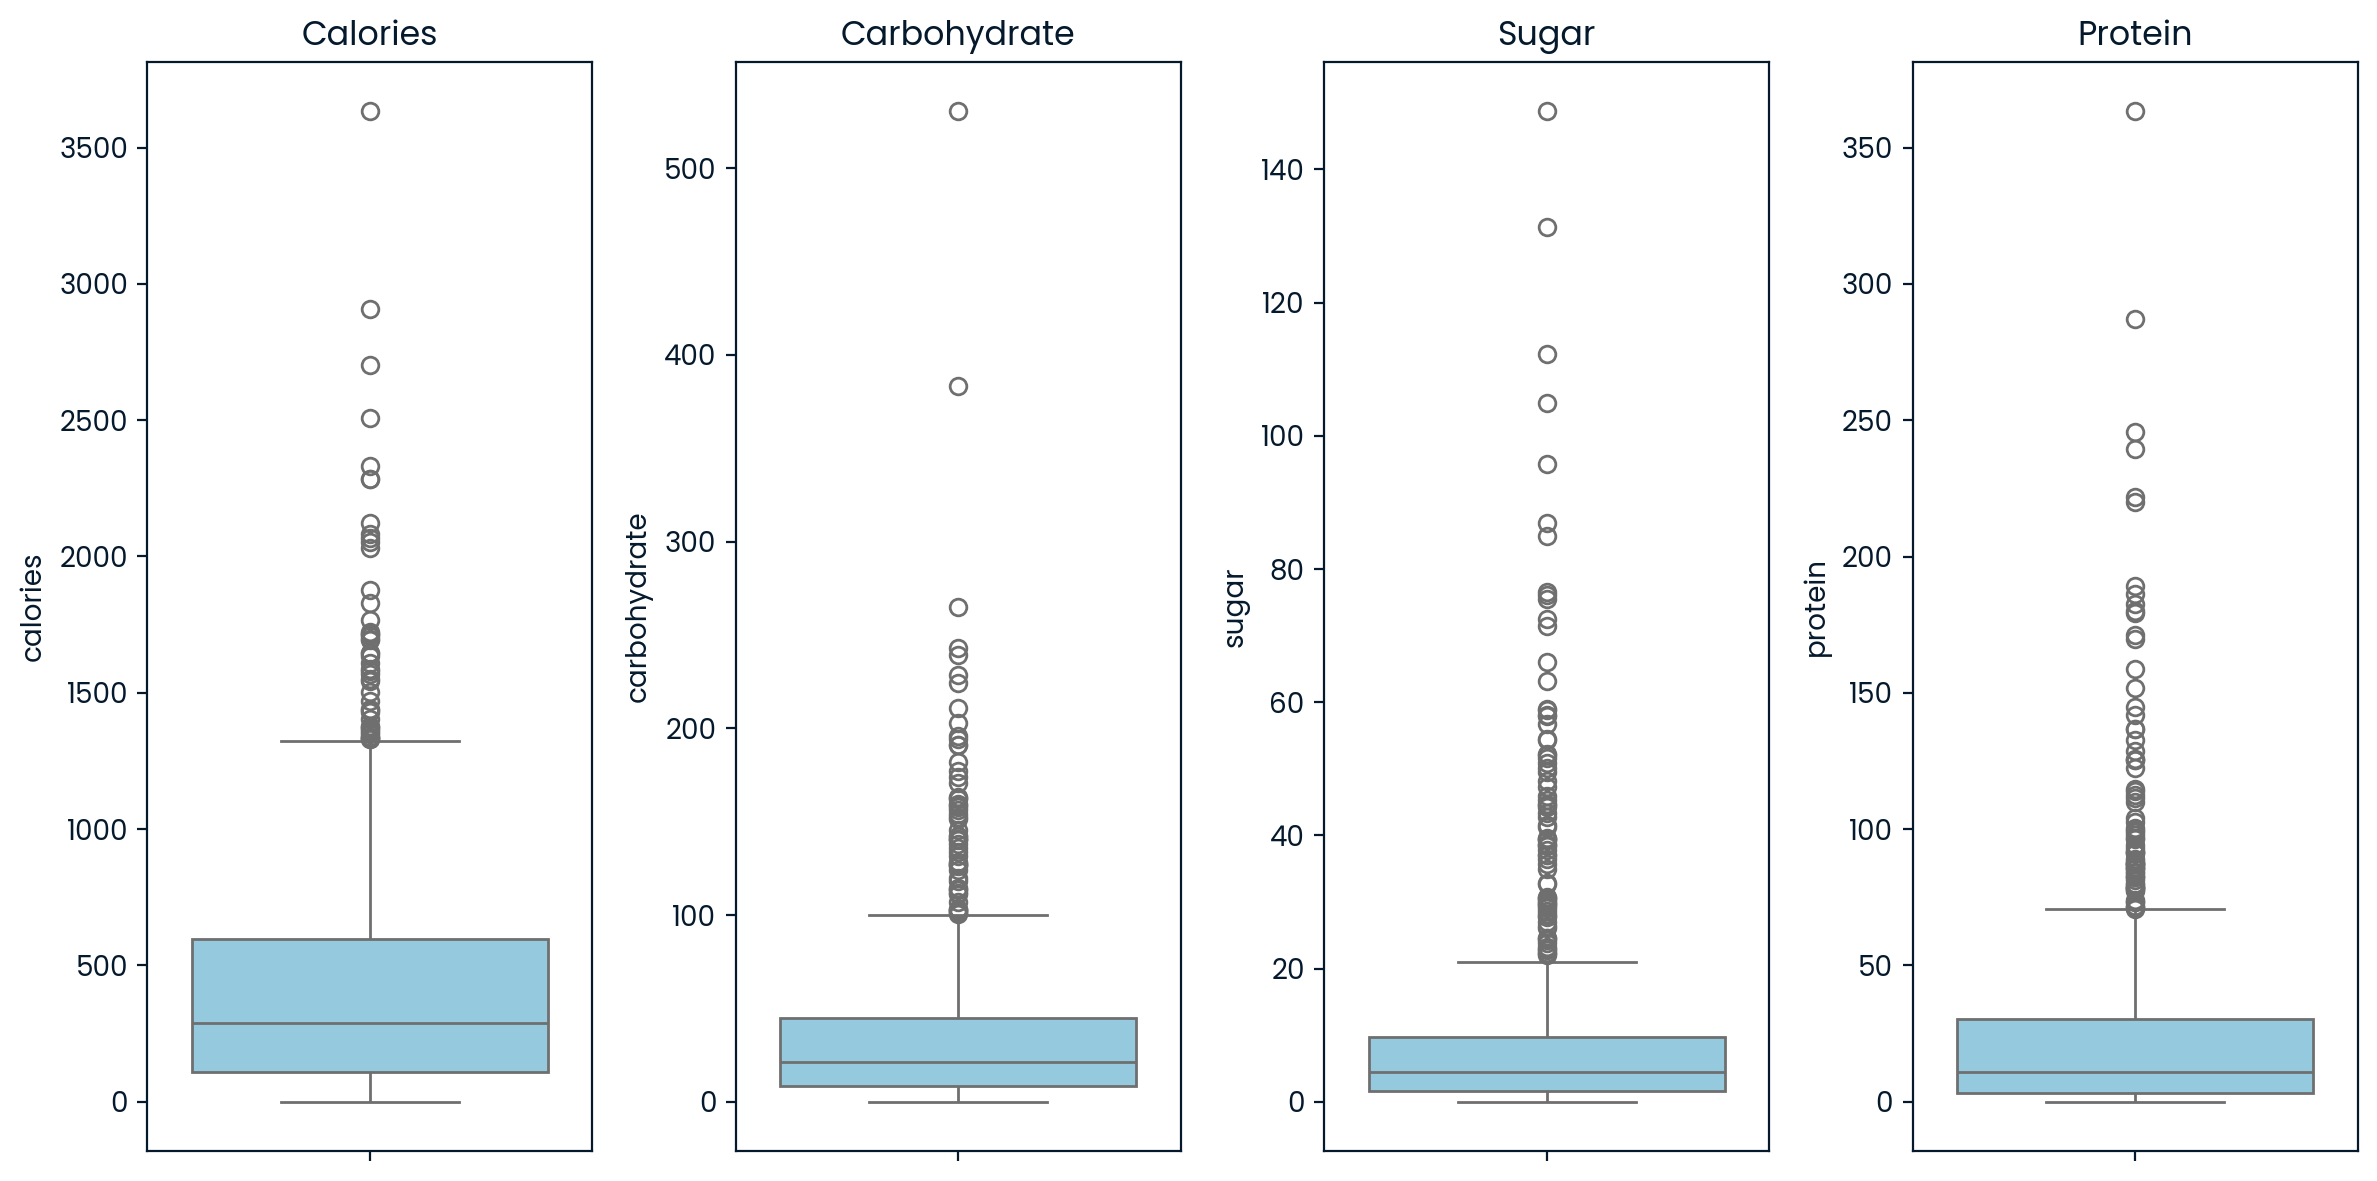

In [73]:
# Boxplots for numeric features 

numeric_features = ['calories','carbohydrate','sugar','protein']

plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(1, len(numeric_features), i)
    sns.boxplot(y=df[feature], color="skyblue")
    plt.title(feature.title())

plt.tight_layout()
plt.show()


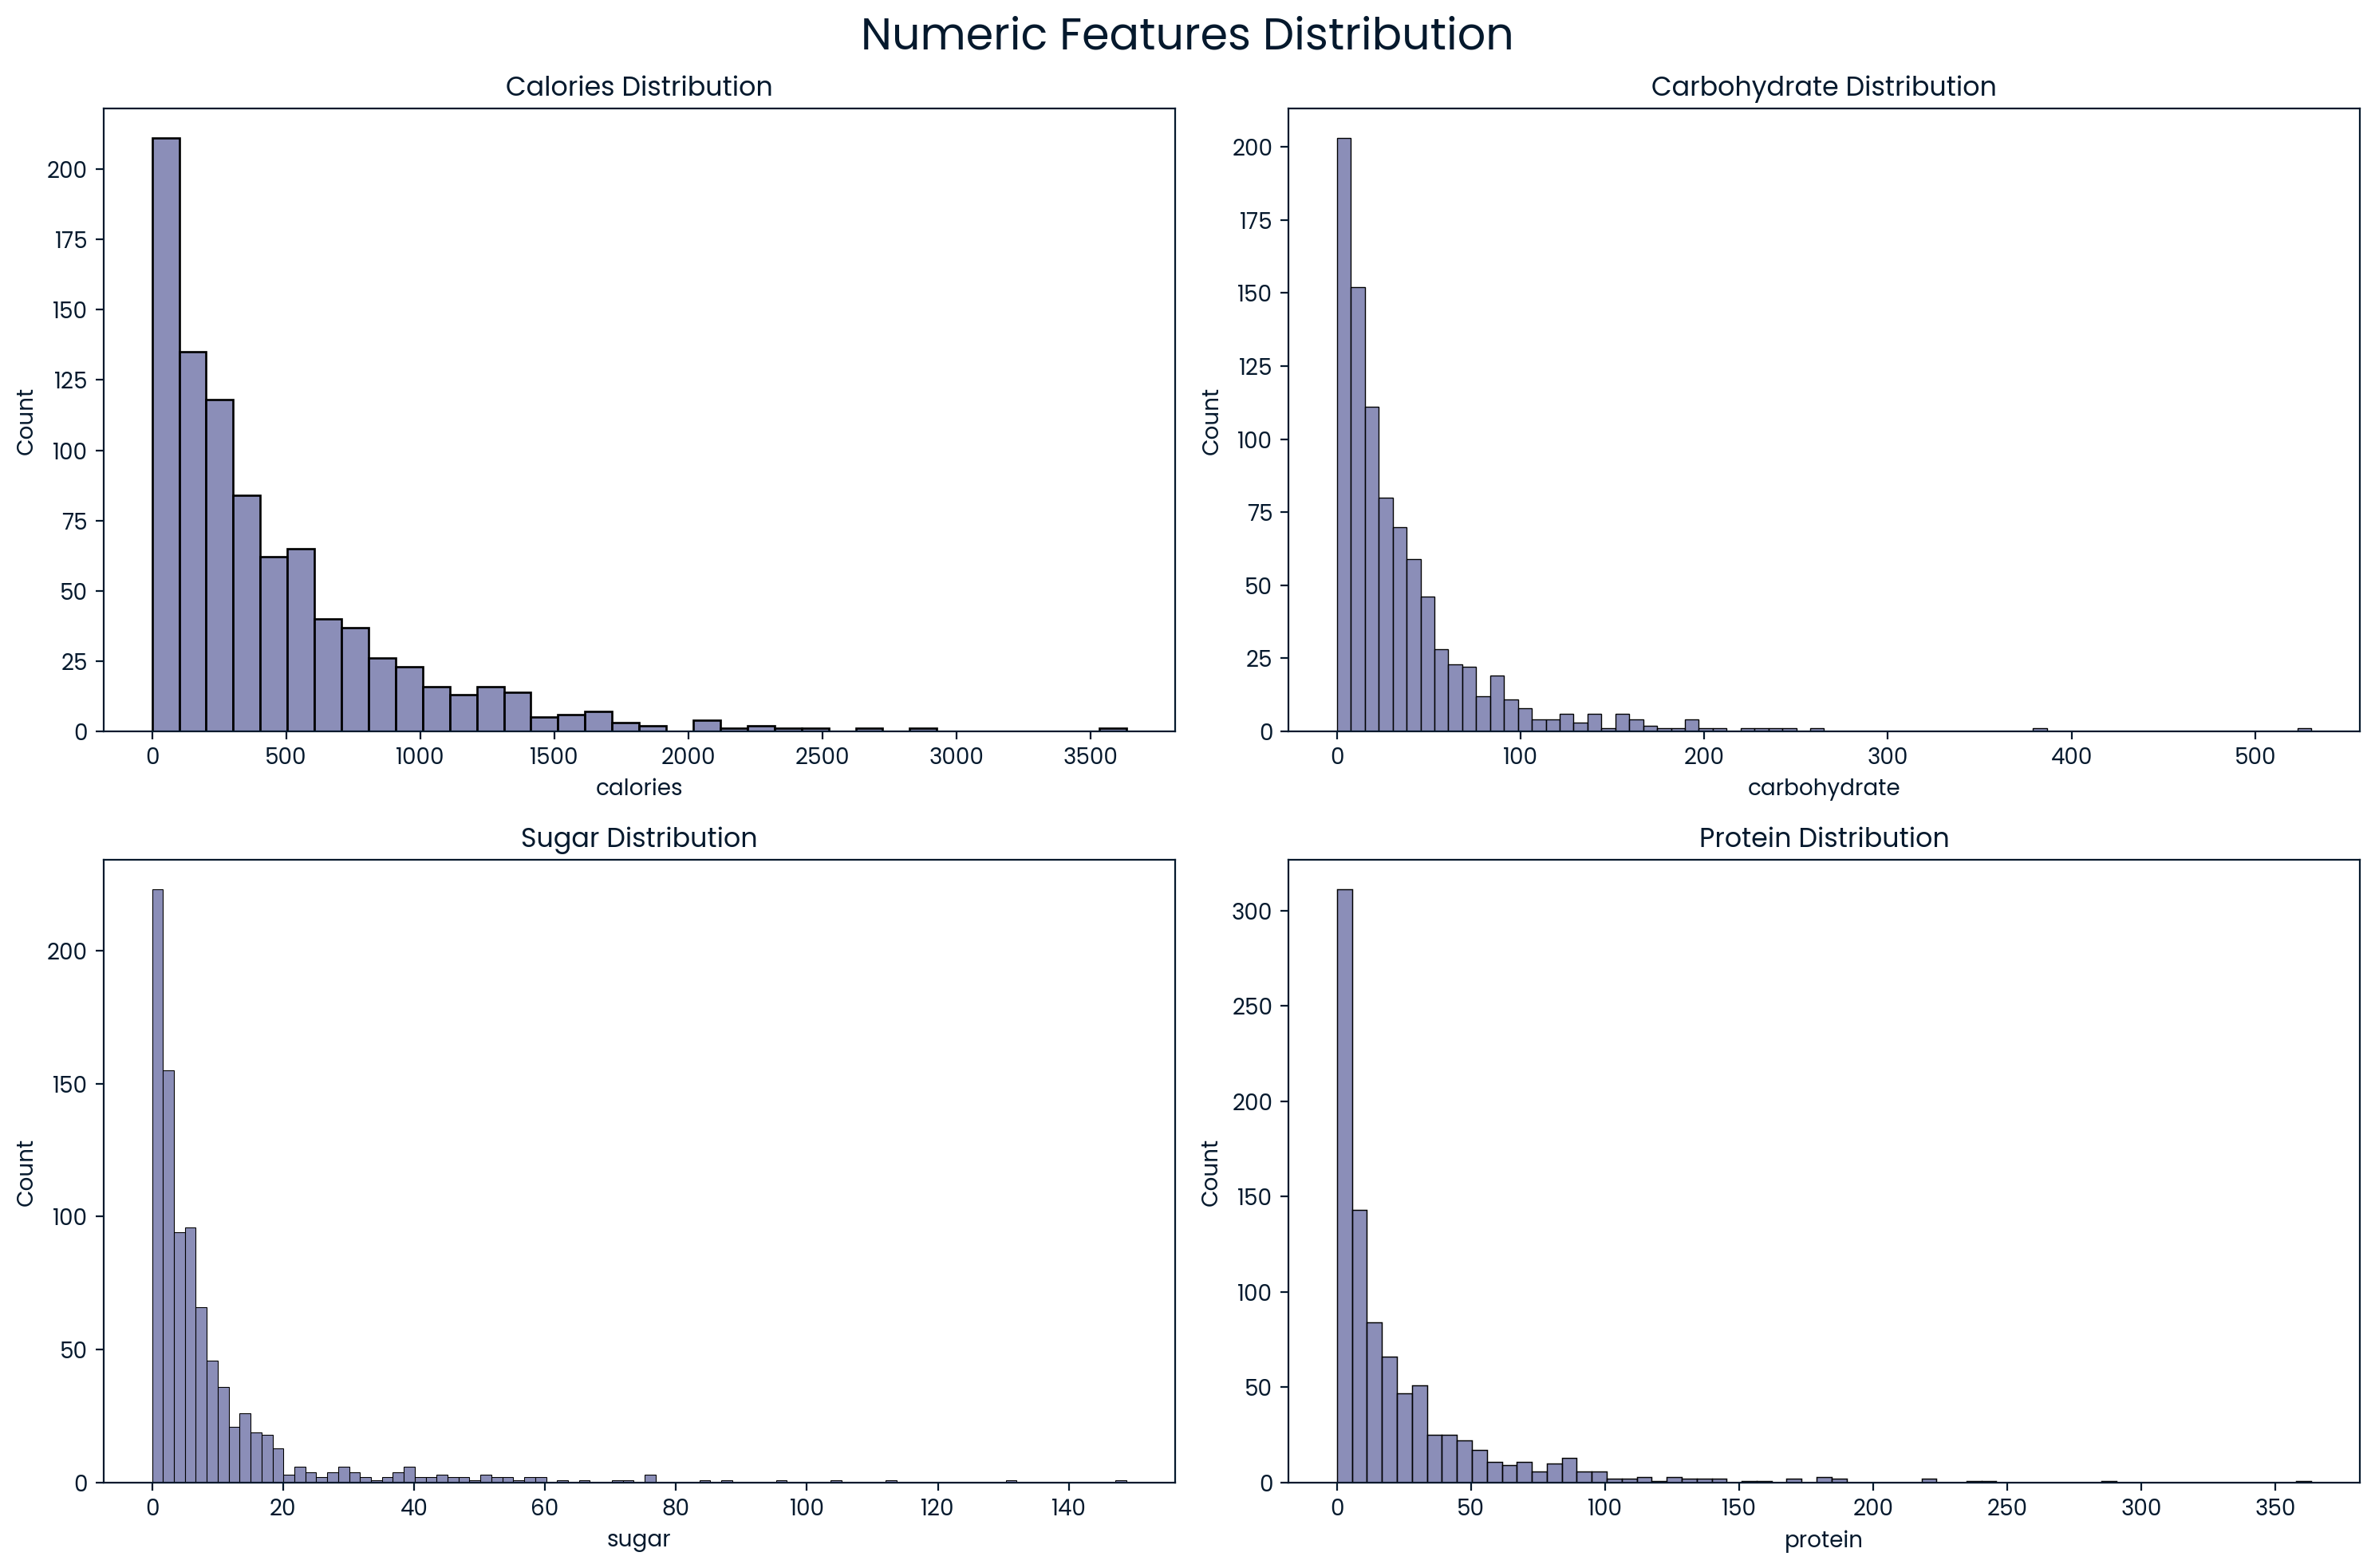

In [74]:
# Plotting distribution of numeric variables
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature])
    plt.title(f'{feature.title()} Distribution')

plt.suptitle('Numeric Features Distribution', fontsize=20)
plt.tight_layout()
plt.show()


While looking for missing values in our data we observed that `calories`, `carbohydrate`, `sugar` and `protein` columns have missing values. After looking at their respective distributions we see all of them are right skewed. For skewed variables like these, median serves as a better metric for imputation rather than mean.

Another important point to note while imputing missing values could be that should we impute based on median of all the recipes in our dataset or have a better way of segregating the data first and then imputing?

In my opinion, grouping by recipe category first and computing the median seems like a more reasonable way of imputing values for these variables since median for a category would serve as a reasonable estimate rather than median for the whole dataset.

In [75]:
df['calories'] = df.groupby('category')['calories'].transform(lambda x: x.fillna(x.median()))
df['carbohydrate'] = df.groupby('category')['carbohydrate'].transform(lambda x: x.fillna(x.median()))
df['sugar'] = df.groupby('category')['sugar'].transform(lambda x: x.fillna(x.median()))
df['protein'] = df.groupby('category')['protein'].transform(lambda x: x.fillna(x.median()))

In [76]:
df.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

After observing the last variable `servings` we observe that it should ideally have integer values but few rows have strings attached to the numbers and the column datatype is object.

We fix this by using regular expressions to remove the strings 'as a snack' and casting the column as integer

In [77]:
df.servings.value_counts(dropna=False)

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [78]:
df['servings'] = df['servings'].str.replace(r'\s*as a snack\s*', '', regex=True).astype('int')

In [79]:
df.servings.value_counts(dropna=False)

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

We check our data again after all the transformations to validate ideal data types and ensure no missing values before heading to exploratory analysis.

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int64  
 7   high_traffic  947 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 59.3+ KB


# Exploratory Analysis

This is a really interesting visualization showing us which categories tend to have higher traffic. Clearly, Vegetable, Potato and Pork are the standout categories with extremely high number of high_traffic recipes while Meat, Dessert also have been resulting in more traffic on the website. 

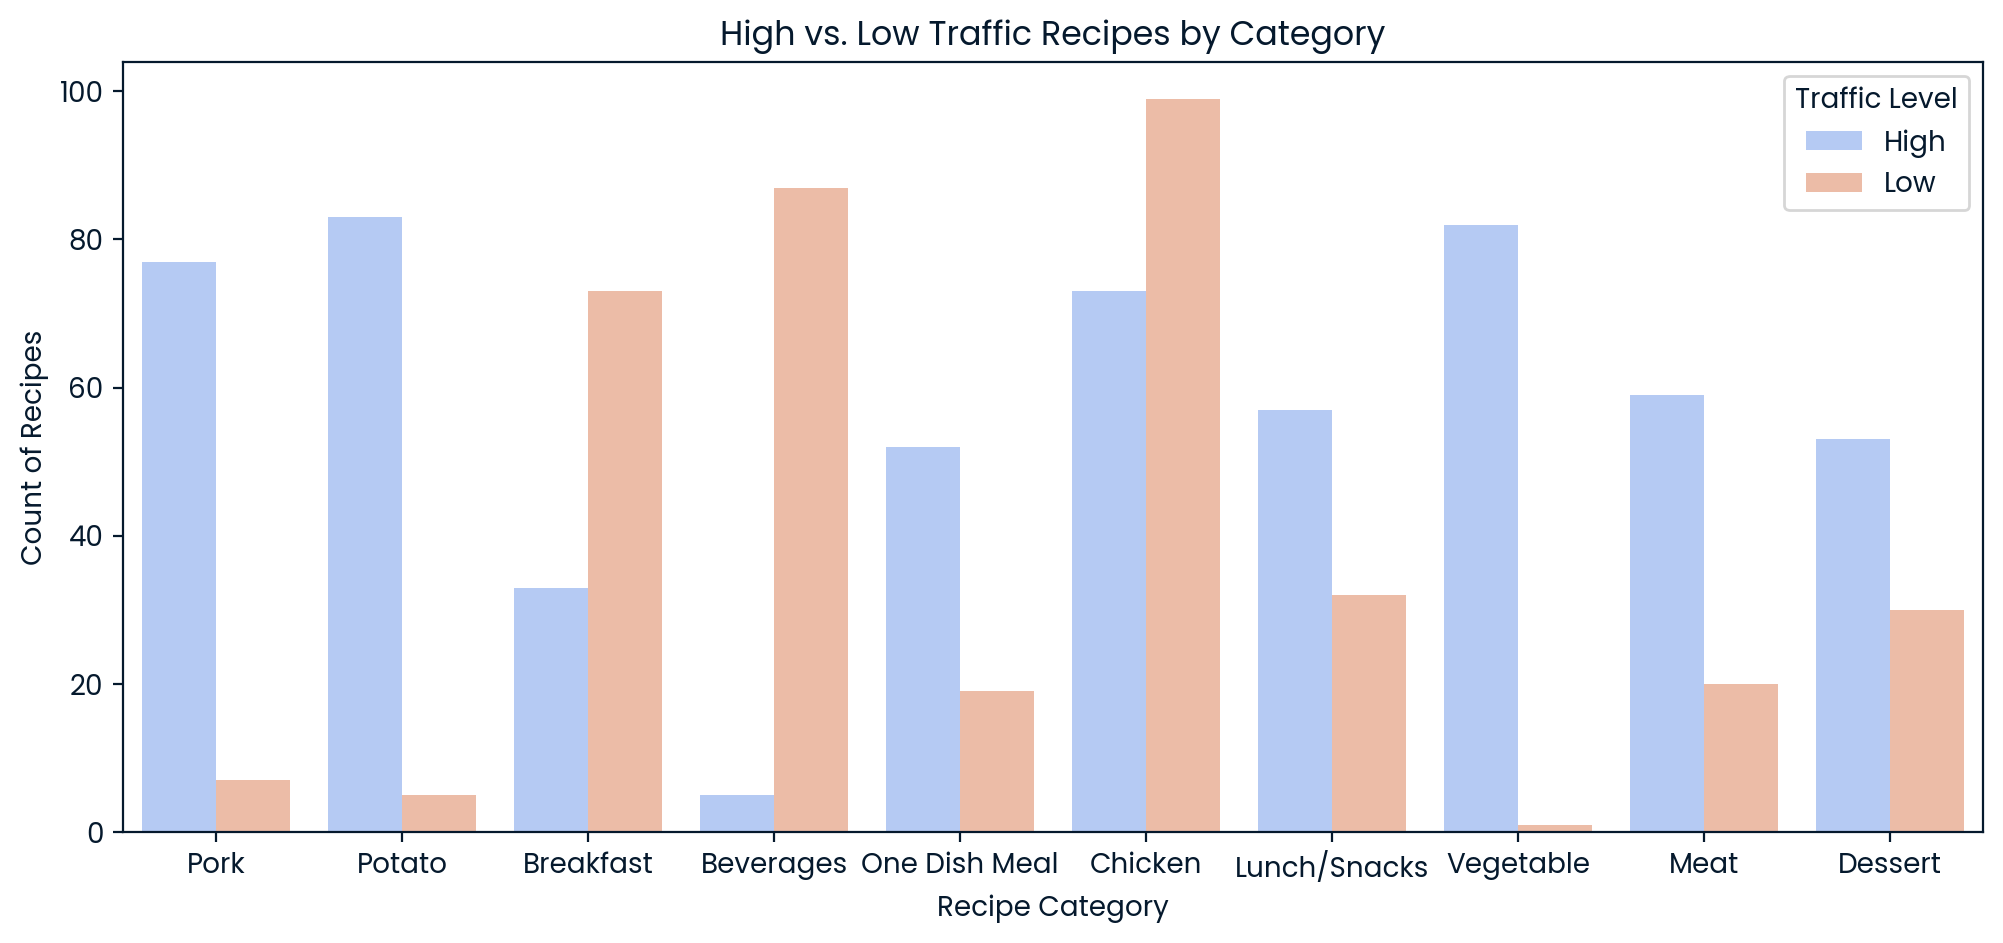

In [81]:
# Category wise countplot across target variable high/low traffic

plt.figure(figsize=(12,5))
sns.countplot(data=df, x='category', hue='high_traffic', palette='coolwarm', hue_order=["High", "Low"])
plt.xlabel("Recipe Category")
plt.ylabel("Count of Recipes")
plt.title("High vs. Low Traffic Recipes by Category")
plt.legend(title="Traffic Level")
plt.show()

The distribution of continuous variables appears largely consistent across high and low-traffic recipes. Variations in peaks for sugar and carbs reflect the density of recipes rather than significant differences in their distributions.

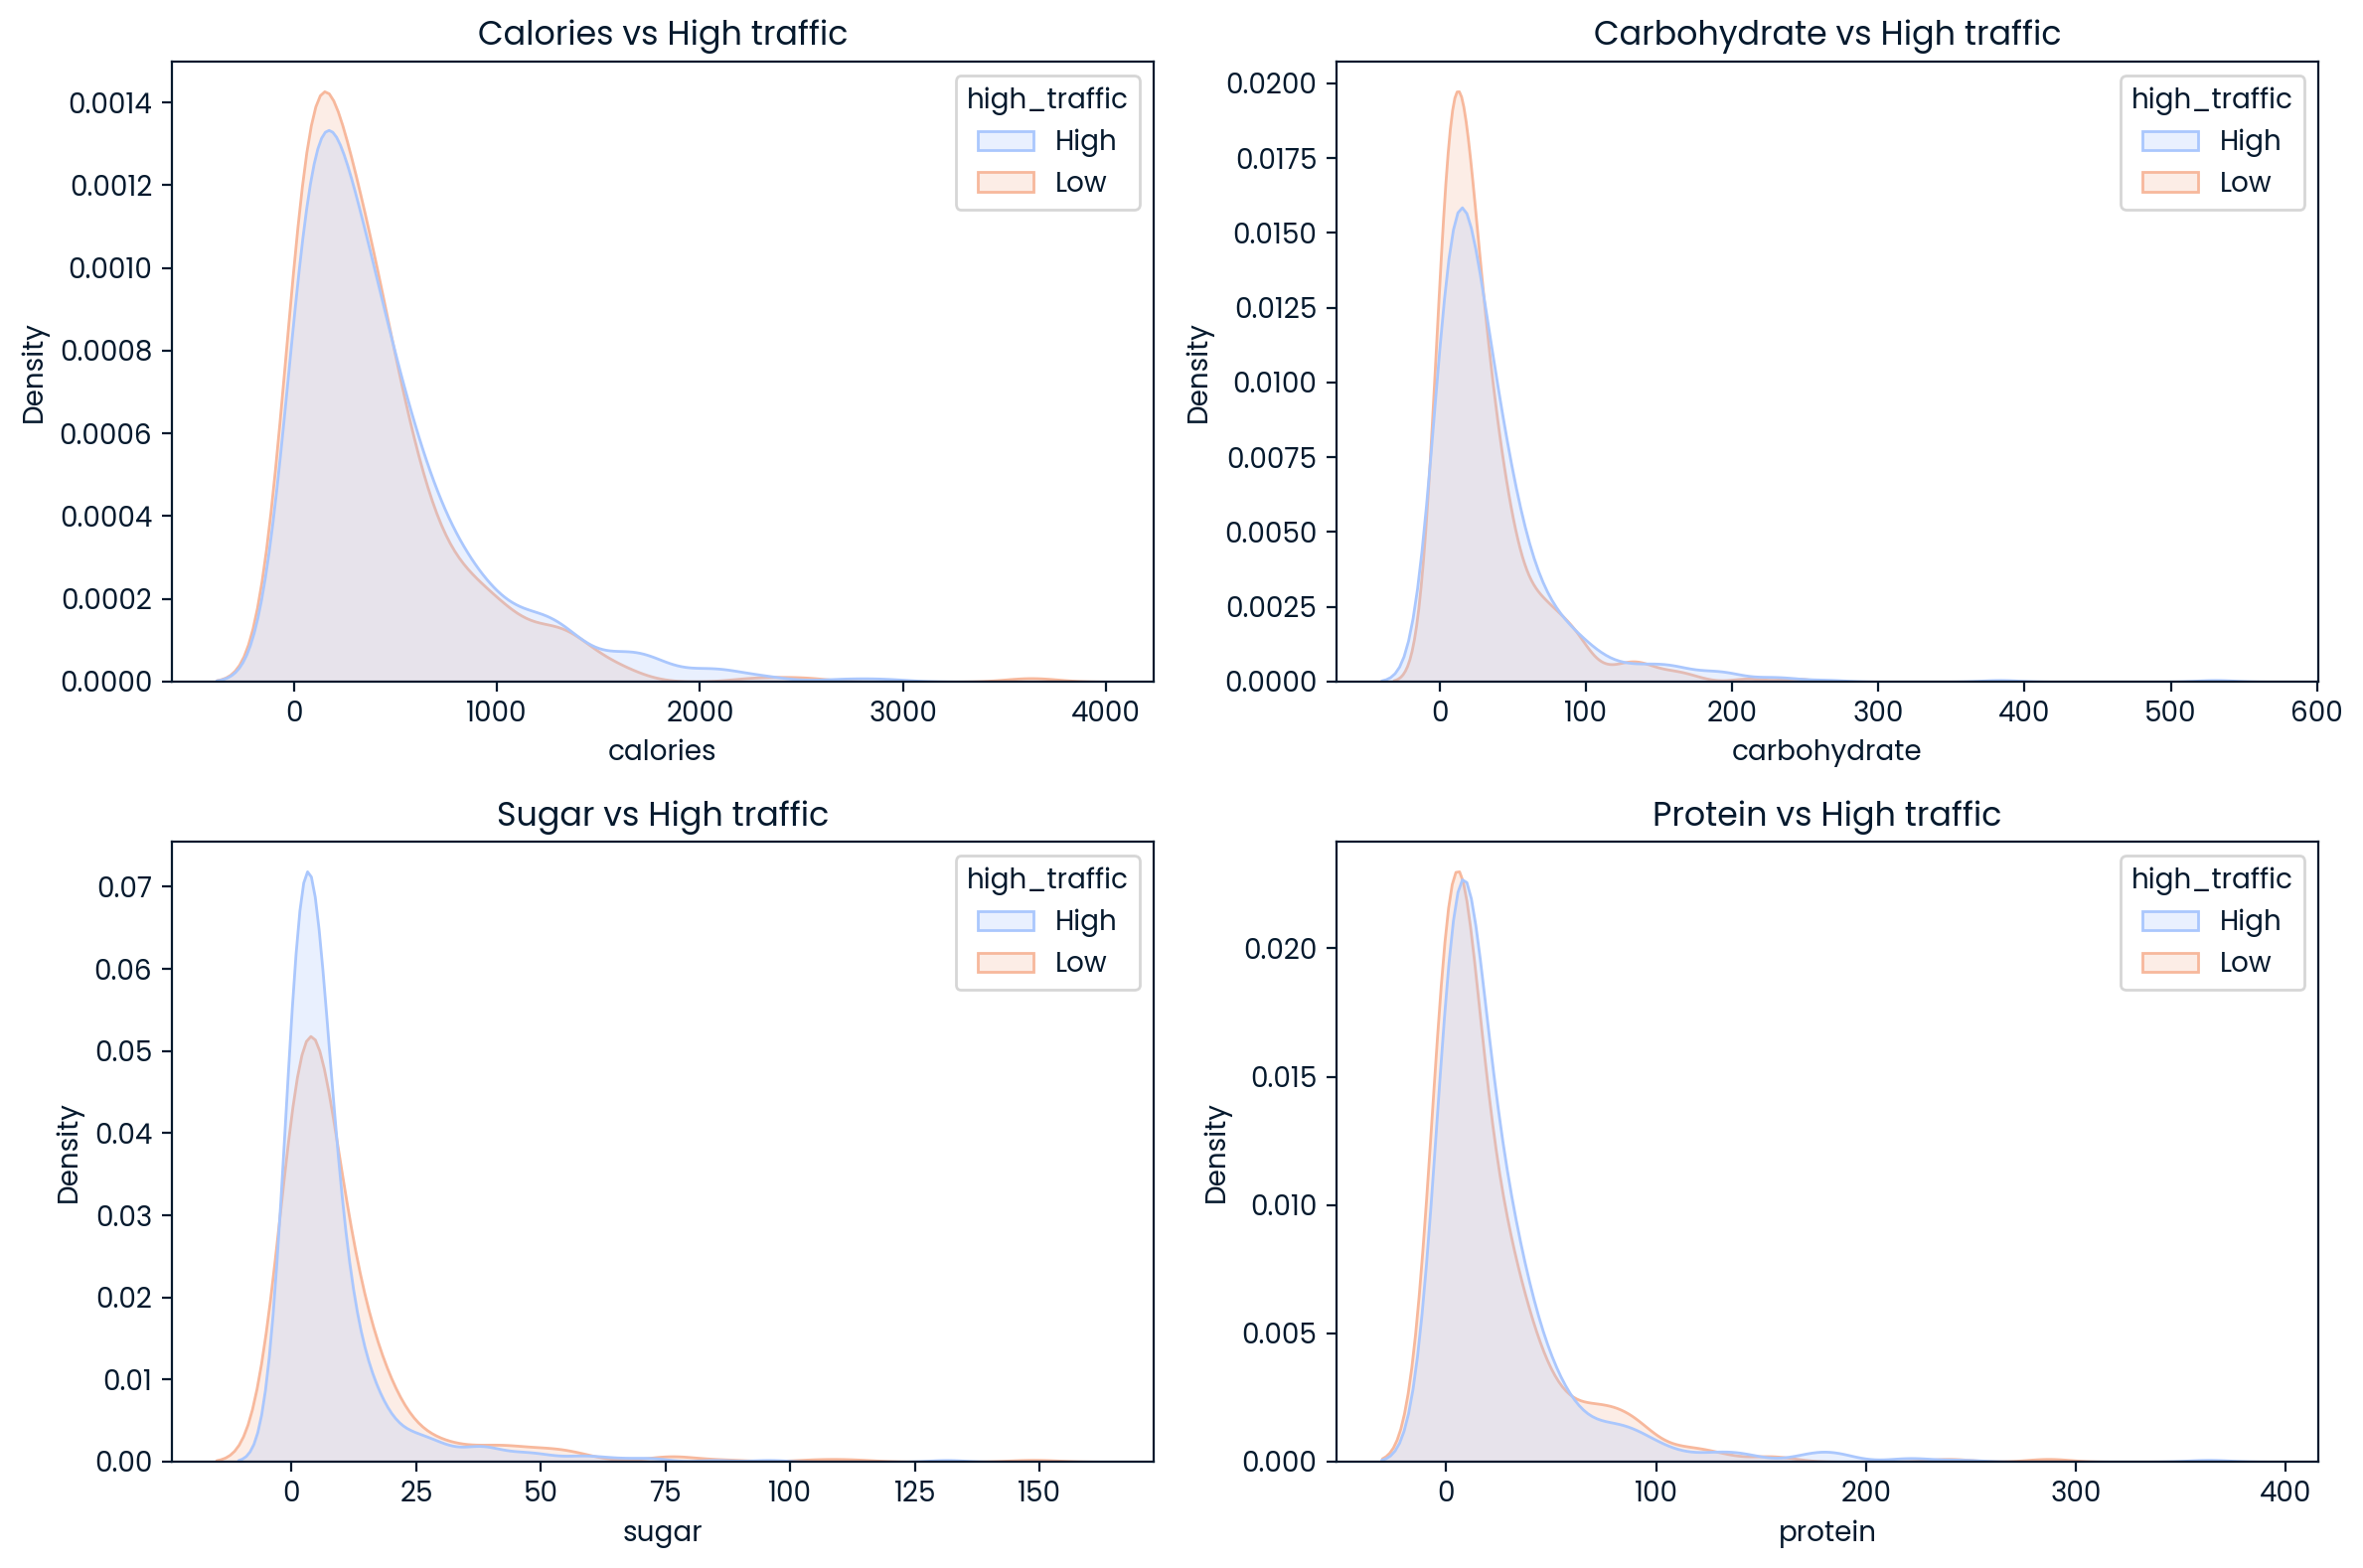

In [82]:
# Kdeplots showing distribution of numerical features across high/low traffic recipes

plt.figure(figsize=(12,8))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2,2,i)
    sns.kdeplot(data=df, x=feature, hue="high_traffic", fill=True, common_norm=False, palette="coolwarm")
    plt.title(f'{feature.title()} vs High traffic')
    
plt.tight_layout()
plt.show()

# Statistical Analysis
## **T-Test Results: Numeric Features**

We performed Welch’s t-test to check if numeric features differ between high and low-traffic recipes. Features with **P-value < 0.05** are statistically significant, indicating meaningful differences in recipe characteristics.


In [83]:
from scipy.stats import ttest_ind

# Separate data by traffic level
high_traffic = df[df["high_traffic"] == "High"]
low_traffic = df[df["high_traffic"] == "Low"]

# Run t-tests and store results
results = []
for feature in numeric_features:
    t_stat, p_val = ttest_ind(high_traffic[feature], low_traffic[feature], nan_policy='omit', equal_var=False)
    results.append({"Feature": feature, "T-statistic": t_stat, "P-value": p_val})

# Convert results to DataFrame
ttest_results = pd.DataFrame(results)

# Add significance column
ttest_results["Statistically Significant"] = ttest_results["P-value"] < 0.05

# Display results
print(ttest_results)


        Feature  T-statistic   P-value  Statistically Significant
0      calories     2.083007  0.037551                       True
1  carbohydrate     2.477672  0.013400                       True
2         sugar    -2.172145  0.030204                       True
3       protein     1.162997  0.245158                      False


The violinplots validate the right skewness of the numeric variables. Sugar has extreme values from dessert category, Protein has extreme values from chicken, carbs have extreme values from potato recipes, whereas calories even though skewed but not as extreme as other variables.

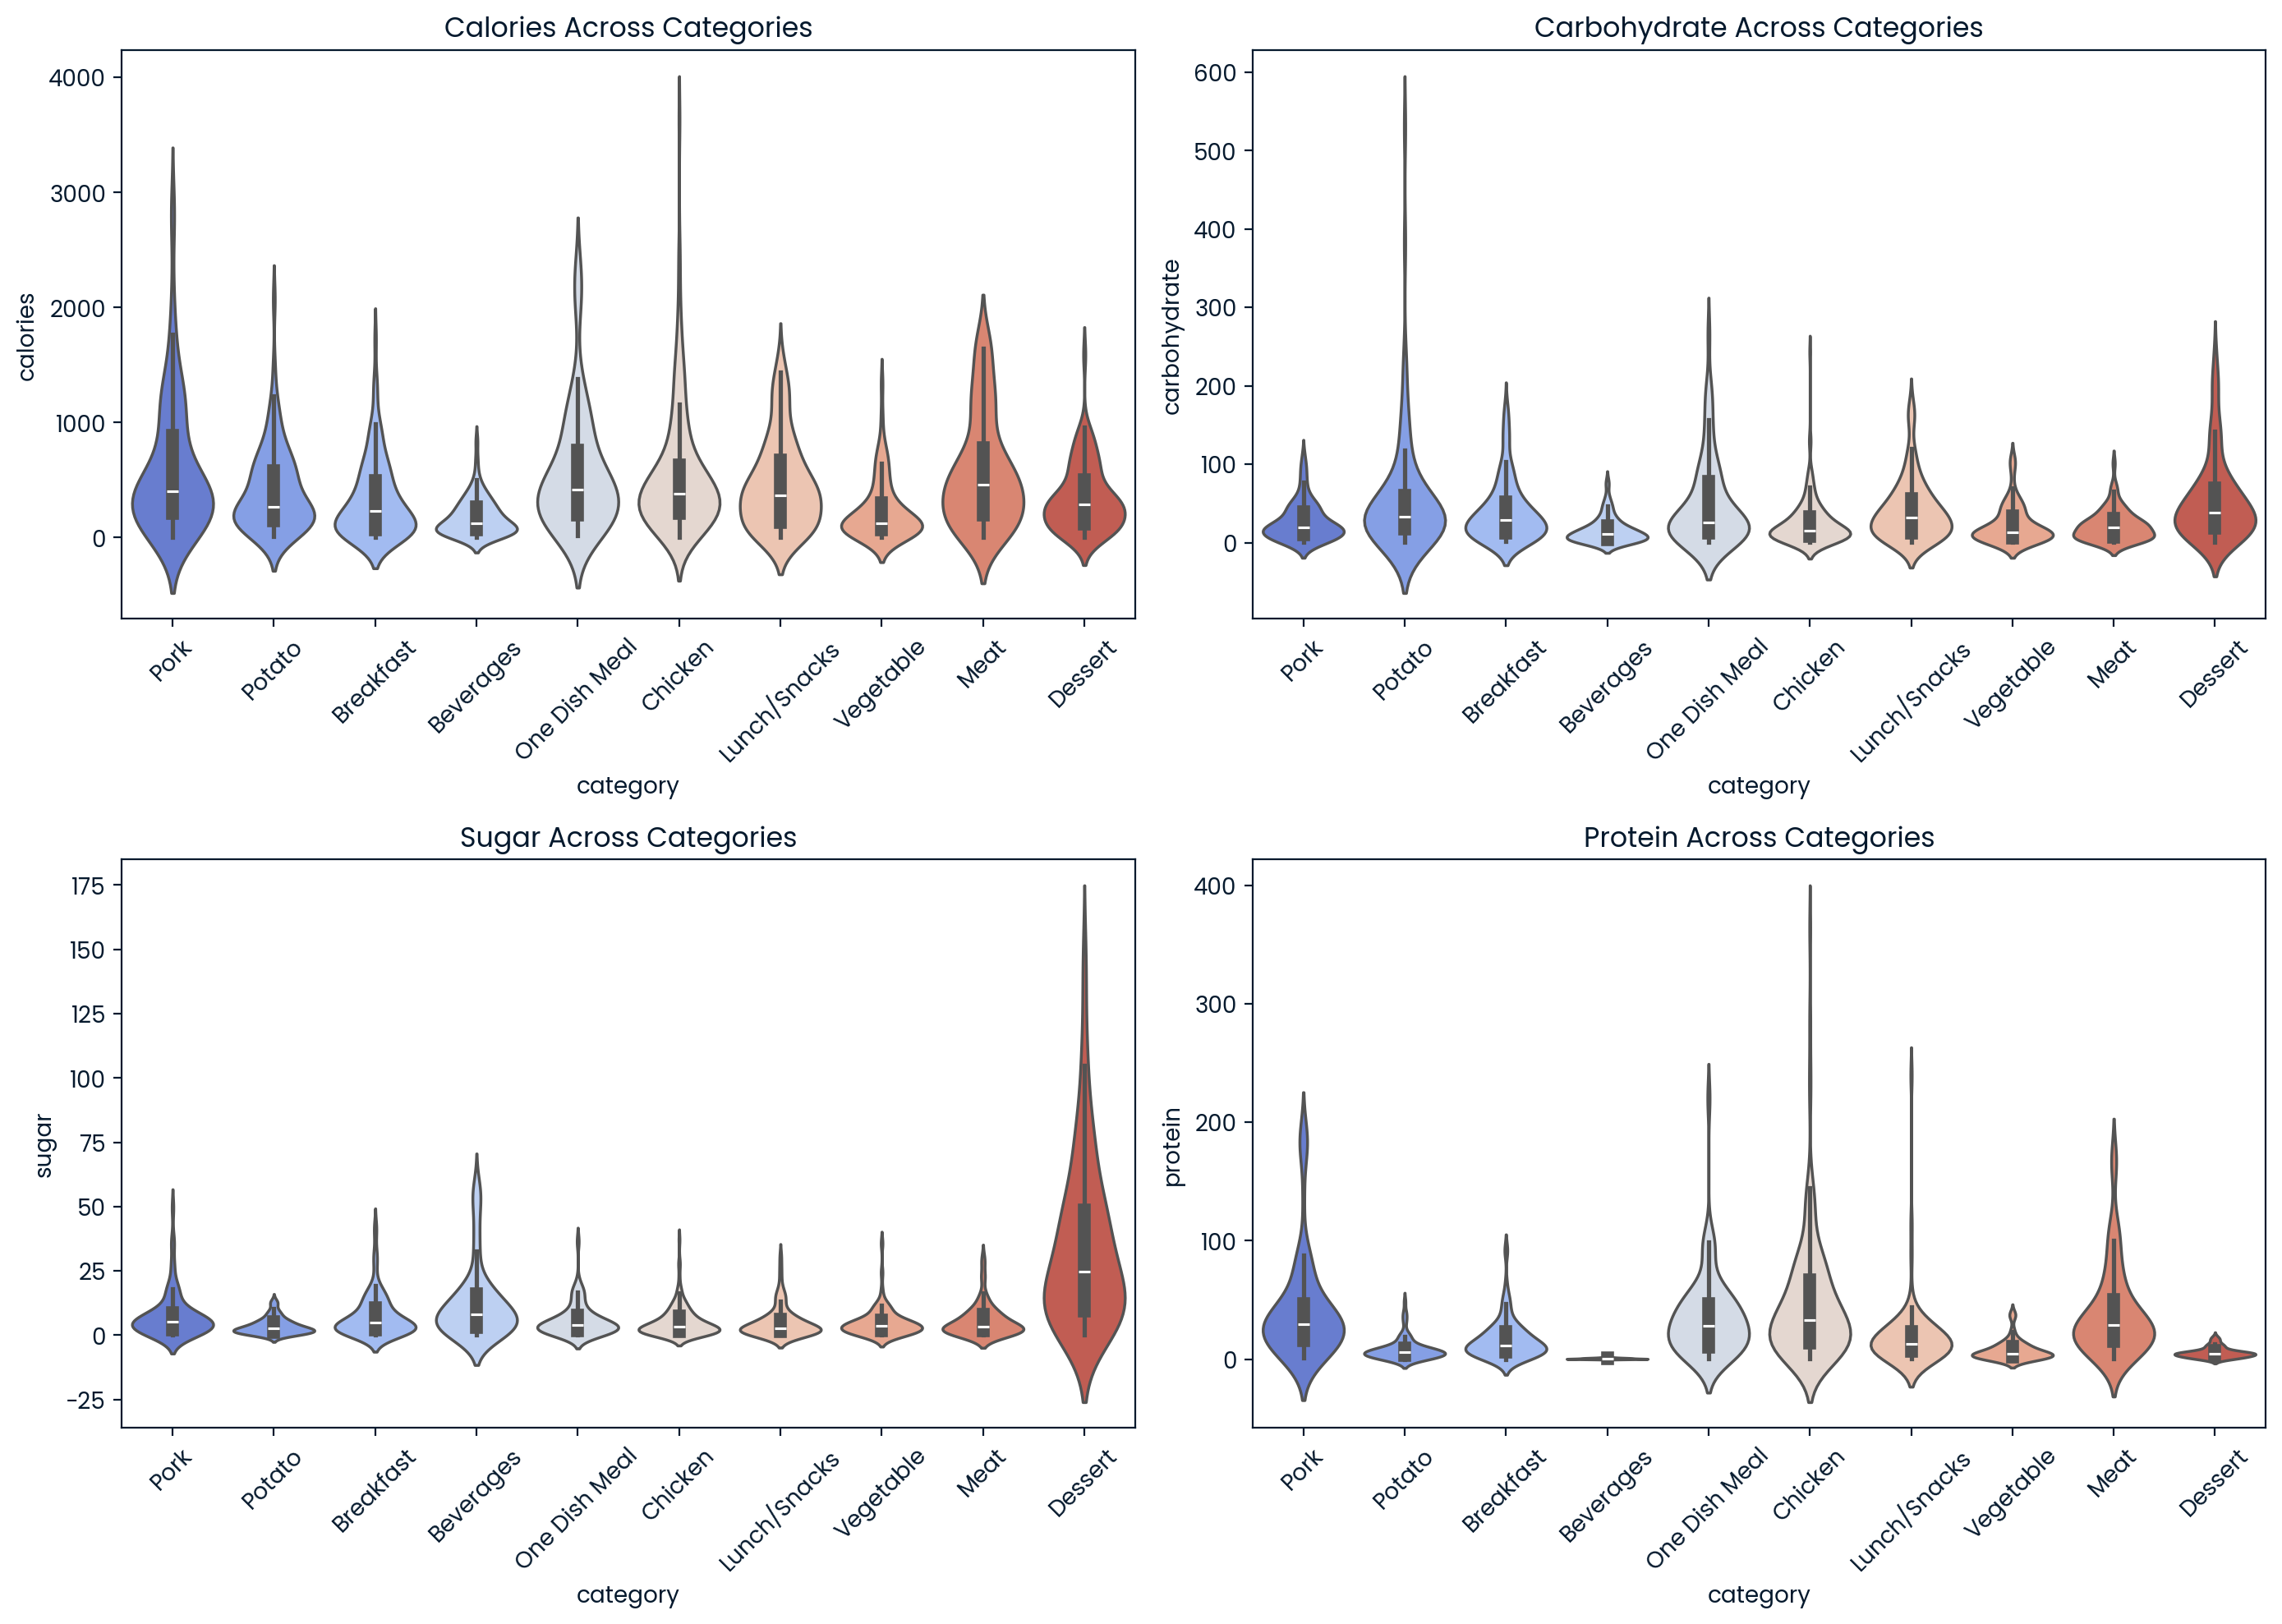

In [84]:
# Violin plots showing distribution of numeric features across recipe categories
plt.figure(figsize=(14, 10))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(data=df, x="category", y=feature, palette="coolwarm")
    plt.xticks(rotation=45)
    plt.title(f"{feature.title()} Across Categories")

plt.tight_layout()
plt.show()


`servings` size does not seem to help distinguish recipes for high or low traffic. Dropping this variable could be considered but we'll include it for now in our predictive models.

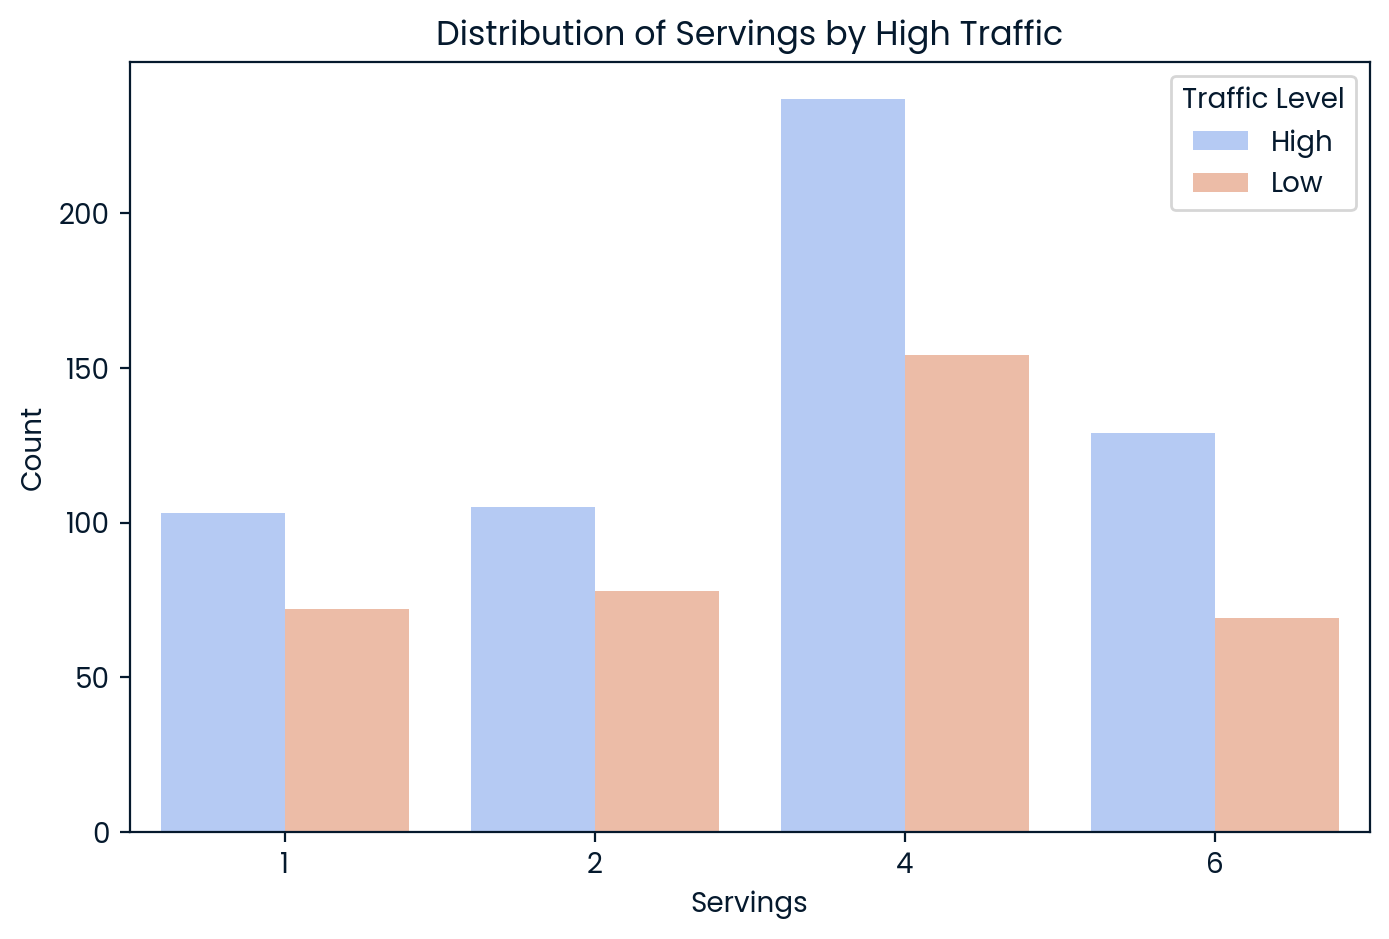

In [85]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="servings", hue="high_traffic", palette="coolwarm", hue_order=["High", "Low"])
plt.title("Distribution of Servings by High Traffic")
plt.xlabel("Servings")
plt.ylabel("Count")
plt.legend(title="Traffic Level")
plt.show()


# Data Preparation for modeling

### This is a binary classification problem to predict whether a recipe will have high or low traffic. We will use Logistic Regression for interpretability and Random Forest for capturing complex patterns. Precision is the key metric to minimize the chance of recommending unpopular recipes.

In [86]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,399.26,19.56,5.23,29.82,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low


For preparation of our data we will:
1. Drop recipe and target variable columns as these would not help in our prediction.
2. Standardize the numeric features such that large values in any feature do not create any bias towards that feature. 
3. For the categorical features we will one hot encode them since recipe categories and serving size do not have any inherent ordinal nature.

In [87]:
df = df.drop(columns=["recipe"])  

categorical_features = ["category", "servings"]
numeric_features = ["calories", "carbohydrate", "sugar", "protein"]

ohe = OneHotEncoder(drop='first', sparse_output=False)  # One-hot encode categorical
tscaler = StandardScaler()  # Standardize numerical features

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', tscaler, numeric_features),
    ('cat', ohe, categorical_features)
])


Steps for modeling will be:
1. Split the data into train and testing set
2. Fit the respective models to training data
3. Predict on the test set
4. Calculate the precision for each model

In [88]:
# Define models
logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42))
])

# Encode target variable
df['high_traffic'] = df['high_traffic'].map({'High': 1, 'Low': 0})

# Split data
X = df.drop(columns=["high_traffic"])
y = df["high_traffic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train models
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Evaluate precision
precision_logreg = precision_score(y_test, y_pred_logreg)
precision_rf = precision_score(y_test, y_pred_rf)

print(f"Logistic Regression Precision: {precision_logreg:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")

Logistic Regression Precision: 0.8977
Random Forest Precision: 0.7925


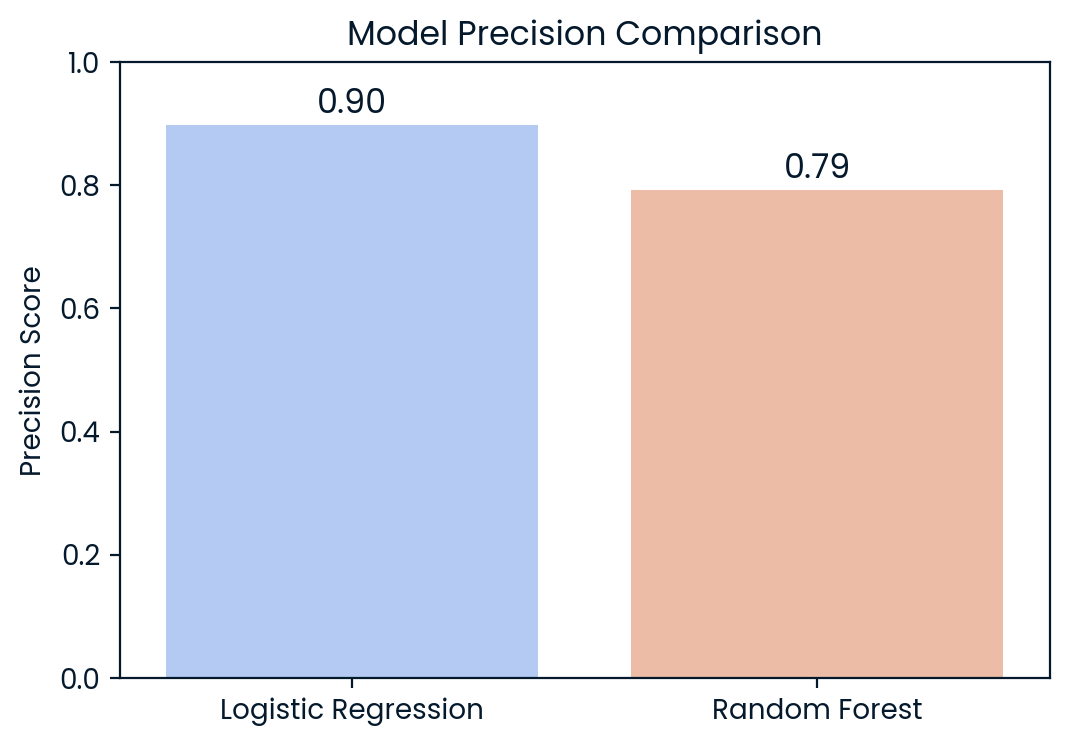

In [89]:
models = ["Logistic Regression", "Random Forest"]
precisions = [precision_logreg, precision_rf]

# Create bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=precisions, palette="coolwarm")
plt.ylim(0, 1)  # Precision values range from 0 to 1
plt.ylabel("Precision Score")
plt.title("Model Precision Comparison")

# Display values on bars
for i, precision in enumerate(precisions):
    plt.text(i, precision + 0.02, f"{precision:.2f}", ha="center", fontsize=12)

plt.show()


Since Logistic Regression models seems to be performing better on our data, we can further dive in to see which **specific features** contributed more towards better **prediction.**

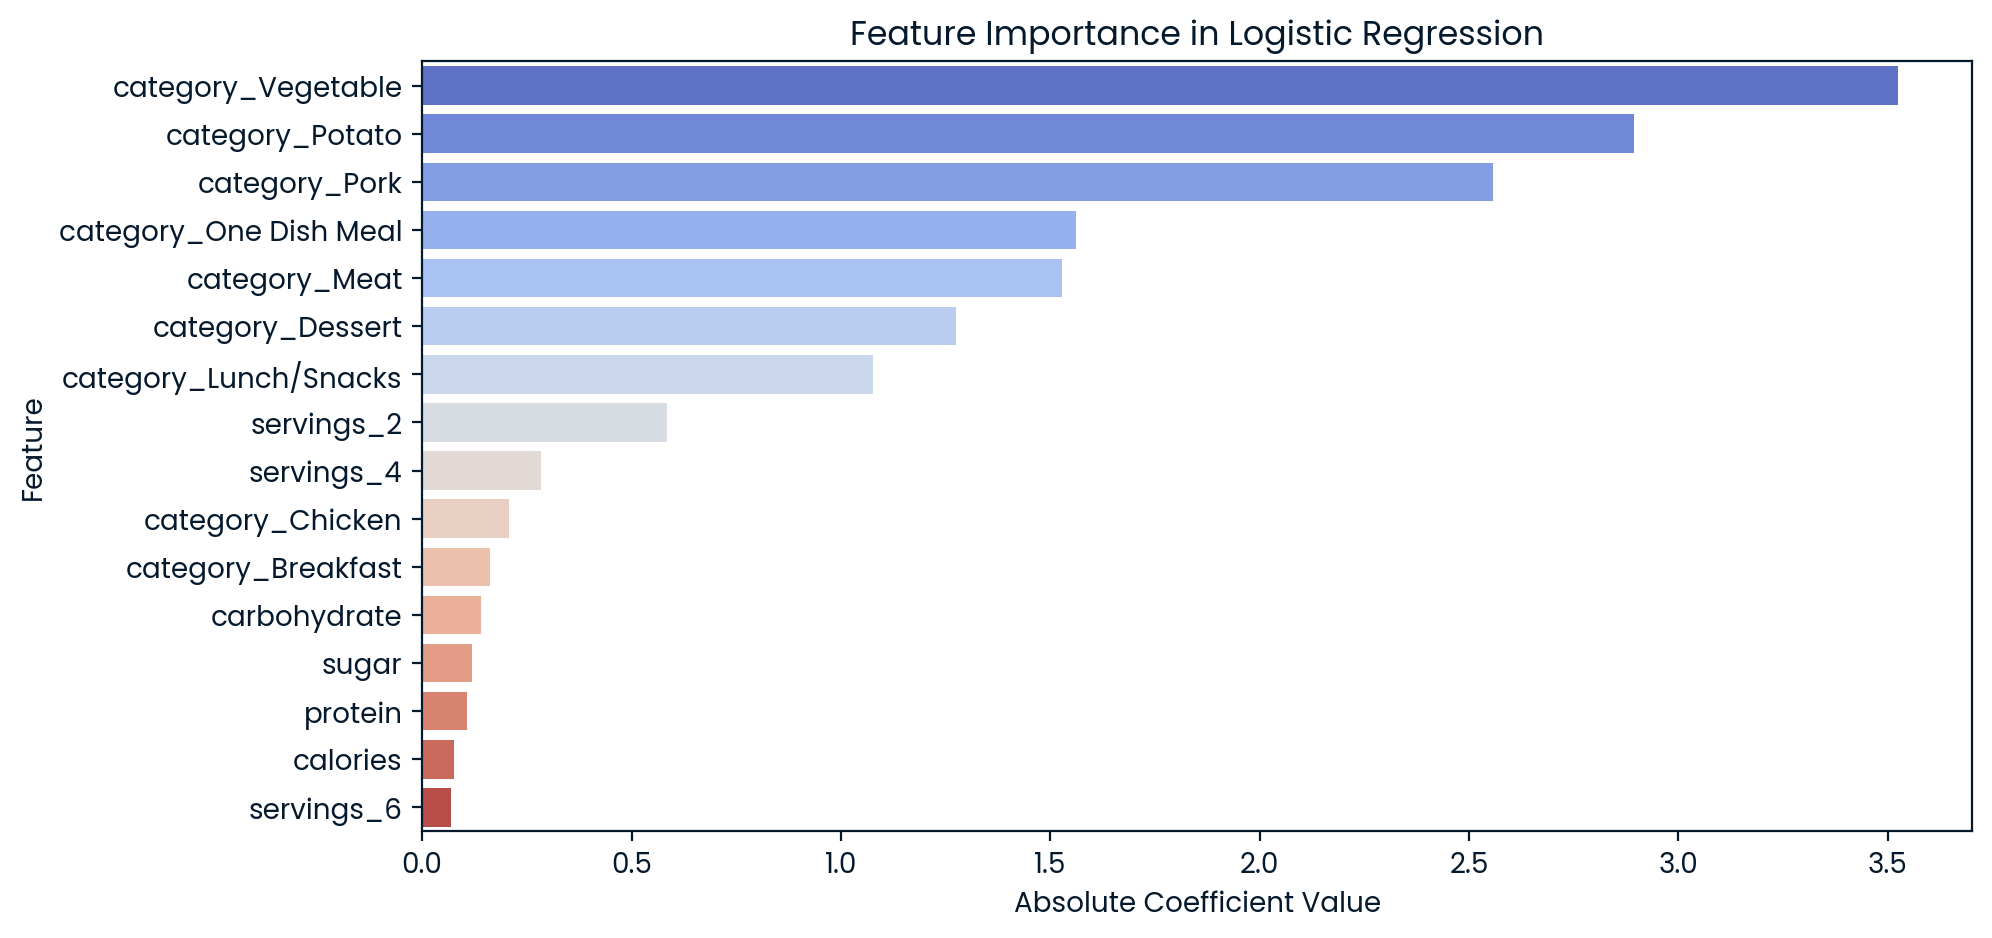

In [90]:
# Extract feature names after preprocessing
ohe_features = logreg.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(ohe_features)

# Get logistic regression coefficients
coefficients = logreg.named_steps['classifier'].coef_.flatten()

# Create DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x='Abs_Coefficient', y='Feature', palette='coolwarm')
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.show()

### **Final Summary & Recommendations**  

#### 🔹 High-Traffic Recipe Categories  
- **Vegetable, Pork, and Potato** categories consistently attracted the most traffic, validated by both exploratory analysis and feature importance.  
- **Recommendation:** Prioritize these categories for homepage placement and promotions.  

#### 🔹 Nutritional Factors & User Preferences  
- **Calories, Carbs, and Sugar** levels were statistically different across high/low traffic recipes.  
- **KPI:** Track these nutritional attributes in trending recipes to better align with user preferences.  
- Further research could explore whether **health-conscious users** prefer lower sugar or carbs in high-traffic recipes.  

#### 🔹 Model Performance & Potential Enhancements  
- **Logistic Regression** achieved **89.77% precision**, surpassing the 80% target.    
- **Next Steps:** Hyperparameter tuning, feature selection, and testing other classification models.  

#### 🔹 Servings Count Shows No Clear Impact on Traffic  
- No significant trend was observed in how servings influenced traffic levels.  
- **Recommendation:** Consider replacing this feature with **prep time, ingredient count, user ratings, or review sentiment**, which may offer stronger predictive power.  

### **Actionable Steps:**  
1. Leverage **top-performing recipe categories** in homepage promotions.  
2. Monitor and analyze **nutritional factors** in recipe popularity trends.  
3. Fine-tune **Logistic Regression** and explore alternative models to improve accuracy.  
4. Expand **data collection** to include additional variables like **user reviews and engagement metrics** for deeper insights. 